In [ ]:
# default_exp callback.PredictionDynamics

# PredictionDynamics

> Callback used to visualize model predictions during training. 

This is an implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on a [blog post](http://localhost:8888/?token=83bca9180c34e1c8991886445942499ee8c1e003bc0491d0) by Andrej Karpathy I read some time ago that I really liked. One of the things he mentioned was this: 
>"**visualize prediction dynamics**. I like to visualize model predictions on a fixed test batch during the course of training. The “dynamics” of how these predictions move will give you incredibly good intuition for how the training progresses. Many times it is possible to feel the network “struggle” to fit your data if it wiggles too much in some way, revealing instabilities. Very low or very high learning rates are also easily noticeable in the amount of jitter." A. Karpathy


In [ ]:
#export
from fastai.callback.all import *
from fastcore.basics import store_attr

In [ ]:
# export
class PredictionDynamics(Callback):
    order, run_valid = 70, True

    def __init__(self, show_perc=1., figsize=(6, 6), alpha=.3, size=30, color='lime', cmap='gist_rainbow'):
        
        """
        Args:
            show_perc:  percent of samples from the valid set that will be displayed. Default: 1 (all). 
                        You can reduce it if the number is too high and the chart is too busy.   
            alpha:      level of transparency. Default:.3. 1 means no transparency.
            figsize:    size of the chart. You may want to expand it if too many classes.
            size:       size of each sample in the chart. Default:30. You may need to decrease it a bit if too many classes/ samples. 
            color:      color used in regression plots.
            cmap:       color map used in classification plots. 

        The red line in classification tasks indicate the average probability of true class.        
        """

        store_attr("show_perc,figsize,alpha,size,color,cmap")

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not self.run:
            return
        self.cat = True if (hasattr(self.dls, "c") and self.dls.c > 1) else False
        if self.show_perc != 1:
            valid_size = len(self.dls.valid.dataset)
            self.show_idxs = np.random.choice(valid_size, int(round(self.show_perc * valid_size)), replace=False)

        # Prepare ground truth container
        self.y_true = []

    def before_epoch(self):
        # Prepare empty pred container in every epoch
        self.y_pred = []

    def after_pred(self):
        if self.training:
            return

        # Get y_true in epoch 0
        if self.epoch == 0:
            self.y_true.extend(self.y.cpu().flatten().numpy())

        # Gather y_pred for every batch
        if self.cat:
            y_pred = torch.gather(F.softmax(self.pred.detach().cpu(), 1), -1, self.y.cpu().reshape(-1, 1).long())
        else:
            y_pred = self.pred.detach().cpu()
        self.y_pred.extend(y_pred.flatten().numpy())

    def after_epoch(self):
        "Plot validation preds during training"

        # Ground truth
        if self.epoch == 0:
            self.y_true = np.array(self.y_true)
            if self.show_perc != 1:
                self.y_true = self.y_true[self.show_idxs]
            self.y_bounds = (np.min(self.y_true), np.max(self.y_true))
            self.min_x_bounds, self.max_x_bounds = np.min(self.y_true), np.max(self.y_true)

        self.y_pred = np.array(self.y_pred)
        if self.show_perc != 1:
            self.y_pred = self.y_pred[self.show_idxs]
        if self.cat:
            self.update_graph(self.y_pred, self.y_true)
        else:
            # Adjust bounds during validation
            self.min_x_bounds = min(self.min_x_bounds, np.min(self.y_pred))
            self.max_x_bounds = max(self.max_x_bounds, np.max(self.y_pred))
            x_bounds = (self.min_x_bounds, self.max_x_bounds)
            self.update_graph(self.y_pred, self.y_true, x_bounds=x_bounds, y_bounds=self.y_bounds)

    def after_fit(self):
        plt.close(self.graph_ax.figure)

    def update_graph(self, y_pred, y_true, x_bounds=None, y_bounds=None):
        if not hasattr(self, 'graph_fig'):
            if self.cat:
                self._cl_names = self.dls.vocab
                self._classes = L(self.dls.vocab.o2i.values())
                self._n_classes = len(self._classes)
                self._h_vals = np.linspace(-.5, self._n_classes - .5, self._n_classes + 1)[::-1]
                _cm = plt.get_cmap(self.cmap)
                self._color = [_cm(1. * c/self._n_classes) for c in range(1, self._n_classes + 1)][::-1]
                self._rand = []
                for i, c in enumerate(self._classes):
                    self._rand.append(.5 * (np.random.rand(np.sum(y_true == c)) - .5))
            self.graph_fig, self.graph_ax = plt.subplots(
                1, figsize=self.figsize)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.graph_ax.clear()
        if self.cat:
            for i, c in enumerate(self._classes):
                self.graph_ax.scatter(y_pred[y_true == c], y_true[y_true == c] + self._rand[i],  color=self._color[i],
                                      edgecolor='black', alpha=self.alpha, linewidth=.5, s=self.size)
                self.graph_ax.vlines(np.mean(y_pred[y_true == c]), i - .5, i + .5, color='r')
            self.graph_ax.vlines(.5, min(self._h_vals), max(self._h_vals), linewidth=.5)
            self.graph_ax.hlines(self._h_vals, 0, 1, linewidth=.5)
            self.graph_ax.set_xlim(0, 1)
            self.graph_ax.set_ylim(min(self._h_vals), max(self._h_vals))
            self.graph_ax.set_xticks(np.linspace(0, 1, 11))
            self.graph_ax.set_yticks(self._classes)
            self.graph_ax.set_yticklabels(self._cl_names)
            self.graph_ax.set_xlabel('probability of true class', fontsize=12)
            self.graph_ax.set_ylabel('true class', fontsize=12)
            self.graph_ax.grid(axis='x', color='gainsboro', linewidth=.2)
        else:
            self.graph_ax.scatter(y_pred, y_true, lw=1, color=self.color,
                                  edgecolor='black', alpha=self.alpha, linewidth=.5, s=self.size)
            self.graph_ax.set_xlim(*x_bounds)
            self.graph_ax.set_ylim(*y_bounds)
            self.graph_ax.plot([*x_bounds], [*x_bounds], color='gainsboro')
            self.graph_ax.set_xlabel('y_pred', fontsize=12)
            self.graph_ax.set_ylabel('y_true', fontsize=12)
            self.graph_ax.grid(color='gainsboro', linewidth=.2)
        title = f'Prediction Dynamics \nepoch: {self.epoch +1}/{self.n_epoch} - valid_loss: {learn.recorder.values[-1][1]:.6f}'
        self.graph_ax.set_title(title)
        self.graph_out.update(self.graph_ax.figure)

In [ ]:
from fastai.data.all import *
from fastai.metrics import *
from tsai.data.all import *
from tsai.models.utils import *
from tsai.learner import *
from tsai.models.InceptionTimePlus import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
check_data(X, y, splits, False)

X      - shape: [360 samples x 24 features x 51 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (360,)  type: memmap  dtype:<U3  n_classes: 6 (60 samples per class) ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']  isnan: False
splits - n_splits: 2 shape: [180, 180]  overlap: [False]


epoch,train_loss,valid_loss,accuracy,time
0,1.750405,1.719900,0.233333,00:05
1,1.311273,1.557137,0.572222,00:05


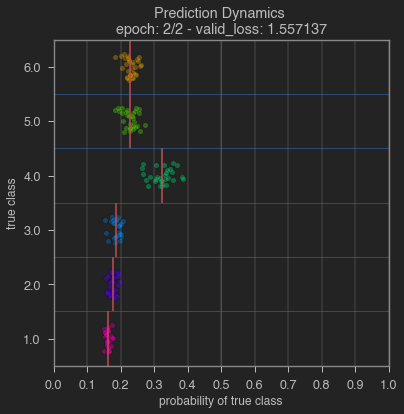

In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
learn = ts_learner(dls, InceptionTimePlus, metrics=accuracy, cbs=PredictionDynamics()) 
learn.fit_one_cycle(2, 3e-3)

In [ ]:
# hide
from tsai.imports import *
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Co